In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import big_model, aflare, calculate_specific_flare_flux, aflare
from funcs.flarefit import log_probability

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest
import emcee
import corner

#

In [2]:
def get_incl(lcs):
    v_rot = lcs['rad'].values*2*np.pi*R_sun / (lcs['Prot_d'].values*u.d)
    vsini = lcs['vsini_kms'].values*u.km/u.s
    e_vsini = lcs['e_vsini_kms'].values*u.km/u.s
    sini = (vsini / v_rot ).decompose()
    #print(sini.decompose(), v_rot.to("km/s"))
    # set values larger than 1 to 1 (must be due to uncertainties in Rstar or vsini):
    #sini[sini.decompose() > 1] = 1.
    incl = np.arcsin(sini.decompose())
    lcs["incl"] = incl
    lcs["incl_err"] = (e_vsini / (v_rot * np.sqrt(1. - sini**2))).decompose()
    return lcs

In [3]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
guesses = pd.read_csv(f"{CWD}/data/summary/results.csv")
props = pd.read_csv(f"{CWD}/data/summary/properties.csv")
#lcs.ID = lcs.ID.astype(int)
#guesses.ID = guesses.ID.astype(int)
guesses

,prefix,ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot,theta_a_init
0,TIC,237880881,6020,298,1331.82418,0.00194,0.77347,0.02975,0.46626,0.01576,8.43,60.0
1,KIC,100004076,10414,886,1358.52754,0.00072,0.49377,0.02388,0.79166,0.06277,8.88,70.0
2,TIC,44984200,3809,135,1588.02740,0.00106,0.65066,0.03073,0.29153,0.00868,2.71,NaN
3,TIC,277539431,4495,394,1641.86831,0.00291,0.89720,0.08459,0.35356,0.03025,4.56,NaN
4,EPIC,212035340,1954494,483655,3437.83750,0.00029,0.05795,0.00631,29.07702,2.06769,4.63,NaN


In [4]:
lcs = lcs.merge(guesses, on=["ID","prefix"], how="outer")
lcs = lcs.merge(props, left_on="ID", right_on="id")

In [5]:
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,dist_err,dist_source,rad,tflux,tlum,kflux,klum,gmag,jmag,kmag
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,0.038400,gaia,0.108176,3.319760e-12,1.119535e+29,6.712990e-13,2.263849e+28,17.8356,13.078,11.771
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,20.512900,mk_dupuy2012,0.115204,6.546160e-13,8.406482e+29,1.394100e-13,1.790276e+29,19.5667,15.894,14.884
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,0.143774,gaia,0.275151,3.492650e-11,8.870689e+30,1.272670e-11,3.232358e+30,14.9796,11.530,10.636
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,0.027472,gaia,0.142339,6.305290e-11,9.308451e+29,2.018160e-11,2.979395e+29,14.4115,10.309,9.268
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,0.106872,gaia,0.145216,5.011190e-11,1.126370e+30,1.380730e-11,3.103479e+29,14.7381,10.630,9.666
5,300741820,8,slc,2,tess,TIC,generic,TESS,NaN,1522.00,...,4.409260,mk_dupuy2012,0.127594,2.711650e-11,1.608939e+30,8.679300e-12,5.149798e+29,15.3277,11.959,11.126


In [6]:
lcs = get_incl(lcs)
target = lcs.iloc[0]
target

ID                              100004076
QCS                                    14
typ                                   slc
cadence_min                             1
mission                               kep
prefix                                KIC
origin                            generic
h_mission                          Kepler
SpT                                    L1
view_start                         1356.5
view_stop                            1361
view_min                              600
view_max                             1050
BJDoff                            2454833
tstart                            1358.55
ampl_min                              NaN
ampl_max                              NaN
RA                                  286.7
Dec                               40.1857
J                                  13.078
R                                     NaN
Gaia_G                            17.8356
vsini_kms                            11.2
e_vsini_kms                       

In [ ]:
from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve
from funcs.custom_detrending import refine_detrended_flux_err
from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve

flck = fetch_lightcurve(target)



t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False)
print(sflux)
F = FlareLightCurve(time=t, detrended_flux=sflux, 
                    detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))
print(F.detrended_flux_err)
flcd = refine_detrended_flux_err(F, mask_pos_outliers_sigma=1.5, 
                                     std_rolling_window_length=15, pad=25)

choice = (t > target.view_start + 1.56) & (t < target.view_stop-1.)
t = t[choice]
flux = sflux[choice]
flux_err = np.nanmean(flcd.detrended_flux_err)
median = np.nanmean(find_iterative_median(F).it_med)
phi = (t - t[0])/target.Prot_d * 2 * np.pi
median

In [8]:

#pd.DataFrame({"phi":phi,"flux":flux, "t":t,"flux_err":flux_err, "median_":median}).to_csv(f"{target.ID}.csv",index=False)
lc = pd.read_csv(f"{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]

In [9]:
median

654.4331454815667

(1.2217304763960306, 0.8594593230103518, 7.9330142937161146)

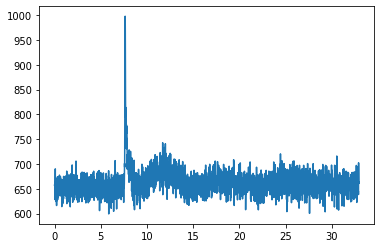

In [10]:

phi_a = (target.t0 - t[0])/target.Prot_d * 2 * np.pi
theta_a = target.theta_a_init*np.pi/180
a = target.ampl
fwhm = target.dur /target.Prot_d * 2 * np.pi/6
i_mu = target.incl
i_sigma = target.incl_err
#theta_a = i_mu +.1
#phi = np.linspace(0, 30*np.pi, N)
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = 15 * np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
# m = big_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
#               phi=phi, num_pts=50, qlum=qlum,
#               Fth=Fth, R=R, median=median)
# flare = aflare(phi, phi_a, fwhm, a*median,)
phi_a_max = phi[-1]
plt.plot(phi,flux)
theta_a, i_mu, phi_a

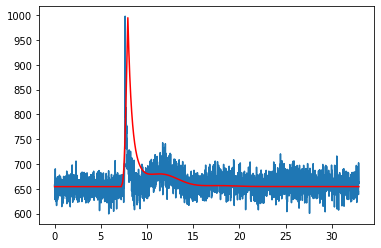

In [11]:
plt.plot(phi,flux)
plt.plot(phi, big_model(phi_a, theta_a, a, fwhm, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="r", alpha=1,)


## Run MCMC

In [ ]:

inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(32, 6))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":i_mu-i_sigma, "phi_a_max":phi_a_max}))
sampler.run_mcmc(pos, 20, progress=True);

In [ ]:
nwalkers, ndim

In [ ]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['flare peak\nlongitude', 'flare\nlatitude', 'relative\namplitude', 'flare\nFWHM', 'inclination \nrad]', 'phi0\n[rad]']
for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
#plt.savefig(f"{target.prefix}{target.ID}_2000_fixed.png",dpi=300)

In [ ]:

flat_samples = sampler.get_chain(discard=1000, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels)# truths=[phi_a, theta_a, a, fwhm,i_mu, phi0]);
plt.savefig(f"{target.prefix}{target.ID}_2000_corner_disc1000_fixed.png",dpi=300)

In [ ]:
.75/np.pi*180-1.1/np.pi*180 #pm 10
1/np.pi*180

In [ ]:
inds = np.random.randint(len(flat_samples), size=50)
plt.figure(figsize=(10,8))
#plt.scatter(flck.time, flck.flux, s=1)
plt.scatter(phi, flux, s=10, c="k")
#plt.errorbar(phi, flux, yerr=flux_err, fmt=".k", capsize=0)

for ind in inds:
    sample = flat_samples[ind]
    phi_a, theta_a, a, fwhm, i, phi0 = sample
   # plt.plot(phi, aflare(phi, phi_a, fwhm, a*median)+ median, c="grey", alpha=0.05, linewidth=3)
    plt.plot(phi, big_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=0.5,)
#plt.plot(phi, flare+median, c="r",linewidth=1)
plt.legend(fontsize=14)
plt.xlabel("time")
plt.ylabel("flux");
plt.savefig(f"{target.prefix}{target.ID}_2000_flarefit_disc1000_fixed.png",dpi=300)

In [ ]:
samples = sampler.chain[:, 10:, :].reshape((-1, ndim))
#samples[:, 2] = np.exp(samples[:, 2])
t0_mcmc, dur_mcmc, ampl_mcmc, c, d, e = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
t0_mcmc, dur_mcmc, ampl_mcmc

In [ ]:
e_t0 = (t0_mcmc[1] + t0_mcmc[2])/2.
e_dur = (dur_mcmc[1] + dur_mcmc[2])/2.
e_ampl = (ampl_mcmc[1] + ampl_mcmc[2])/2.

In [ ]:

def ED(t, t0, dur, ampl, median):
    x = t * 60.0 * 60.0 * 24.0
    return np.sum(np.diff(x) * aflare(t, t0, dur, ampl)[:-1]) / (dur * 6 * median)

In [ ]:

def t0_ED(x):
    return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
def dur_ED(x):
    return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
def ampl_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
def median_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

In [ ]:
check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
assert E_median == pytest.approx(E_median,rel=1e-4)
e_median, median

In [ ]:
EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
EDval,e_ED

In [ ]:
with open(f"{CWD}/data/summary/results.csv", "a") as k:
    stri = (f"{target.prefix} {target.ID},{EDval:.0f},{e_ED:.0f},"\
            f"{t0_mcmc[0]:.5f},{e_t0:.5f},"\
            f"{dur_mcmc[0]*6:.5f},{e_dur*6:.5f},"\
            f"{ampl_mcmc[0]/median:.5f},{e_ampl/median:.5f}\n"\
            f"{period.value:.2f}")
   # stri = "ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot_h\n"
    k.write(stri)